In [23]:
import os, re, json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


In [ ]:
ROOT = Path("disc1")          # Folder containing OAS1
META = Path("oasis_cross-sectional-5708aa0a98d82080.xlsx")  # Metadata


In [ ]:
df_meta = pd.read_excel(META)

df_meta.columns = [c.lower() for c in df_meta.columns]

# Extract OASIS_ID from any column that contains it
def extract_oasis_id_from_row(row):
    for x in row.astype(str).values:
        m = re.search(r"(OAS1_\d{4})", x)
        if m:
            return m.group(1)
    return None

df_meta["oasis_id"] = df_meta.apply(extract_oasis_id_from_row, axis=1)

# Create label: prefer 'group' if present, otherwise use CDR >= 0.5
if "group" in df_meta.columns:
    df_meta["label"] = df_meta["group"].astype(str).str.lower().str.contains("dement").astype(int)
    label_definition = "Group (Demented=1, Control=0)"
elif "cdr" in df_meta.columns:
    df_meta["label"] = (df_meta["cdr"].astype(float) >= 0.5).astype(int)
    label_definition = "CDR >= 0.5"
else:
    df_meta["label"] = np.nan
    label_definition = "Unknown"

print("Metadata columns:", df_meta.columns.tolist())
print("Label definition:", label_definition)
df_meta.head()


Metadata columns: ['id', 'm/f', 'hand', 'age', 'educ', 'ses', 'mmse', 'cdr', 'etiv', 'nwbv', 'asf', 'delay', 'oasis_id', 'label']
Label definition: CDR >= 0.5


,id,m/f,hand,age,educ,ses,mmse,cdr,etiv,nwbv,asf,delay,oasis_id,label
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN,OAS1_0001,0
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN,OAS1_0002,0
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN,OAS1_0003,1
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN,OAS1_0004,0
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN,OAS1_0005,0


In [4]:
def parse_fseg_txt(txt_path):
    csf = gm = wm = None
    with open(txt_path, "r", errors="ignore") as f:
        for line in f:
            if line.strip().startswith("Volumes:"):
                nums = re.findall(r"[-+]?\d*\.\d+|\d+", line)
                if len(nums) >= 3:
                    csf, gm, wm = map(float, nums[:3])
                break
    return csf, gm, wm

# Collect features
rows = []
for txt in ROOT.rglob("*_fseg.txt"):
    m = re.search(r"(OAS1_\d{4})", str(txt))
    if not m: 
        continue
    sid = m.group(1)
    csf, gm, wm = parse_fseg_txt(txt)
    if csf is None:
        continue
    rows.append({
        "OASIS_ID": sid,
        "csf": csf,
        "gm": gm,
        "wm": wm,
        "gm_wm_ratio": gm / wm,
        "brain_total": csf + gm + wm
    })

df_feats = pd.DataFrame(rows)
print("Parsed subjects:", len(df_feats))
df_feats.head()


Parsed subjects: 39


,OASIS_ID,csf,gm,wm,gm_wm_ratio,brain_total
0,OAS1_0001,428136.9,740840.2,498315.1,1.486690,1667292.2
1,OAS1_0002,316280.9,810748.6,540358.6,1.500390,1667388.1
2,OAS1_0003,486149.8,719086.6,462046.4,1.556308,1667282.8
3,OAS1_0004,326165.7,816690.4,524554.6,1.556922,1667410.7
4,OAS1_0005,254128.9,887191.9,526136.5,1.686239,1667457.3


In [5]:
df = df_feats.merge(df_meta, on="OASIS_ID", how="left")
df = df.dropna(subset=["label"])
print("Merged shape:", df.shape)
df.head(3)


Merged shape: (39, 19)


,OASIS_ID,csf,gm,wm,gm_wm_ratio,brain_total,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay,label
0,OAS1_0001,428136.9,740840.2,498315.1,1.486690,1667292.2,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN,0
1,OAS1_0002,316280.9,810748.6,540358.6,1.500390,1667388.1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN,0
2,OAS1_0003,486149.8,719086.6,462046.4,1.556308,1667282.8,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN,1


In [ ]:
print("Rows after merge:", len(df))
print("Label counts:", df["label"].value_counts(dropna=False).to_dict())
print("Any NaNs in features?", df[["csf","gm","wm","brain_total","gm_wm_ratio"]].isna().any().to_dict())

# Check that age exists and looks reasonable
if "Age" not in df.columns:
    print("Columns:", df.columns.tolist())
    raise KeyError("Expected 'age' after standardization. If your sheet uses 'age at exam', rename it to 'age'.")

print("Age summary:", df["Age"].describe().to_dict())

if "group" in df.columns:
    keep_mask = df["group"].str.lower().str.contains("dement|nondement|control", na=False)
    df = df[keep_mask].copy().reset_index(drop=True)
    print("After keeping clear groups, rows:", len(df))
    print("New label counts:", df["label"].value_counts().to_dict())


Rows after merge: 39
Label counts: {0: 27, 1: 12}
Any NaNs in features? {'csf': False, 'gm': False, 'wm': False, 'brain_total': False, 'gm_wm_ratio': False}
Age summary: {'count': 39.0, 'mean': 54.97435897435897, 'std': 25.382844578974552, 'min': 18.0, '25%': 27.5, '50%': 58.0, '75%': 80.0, 'max': 89.0}


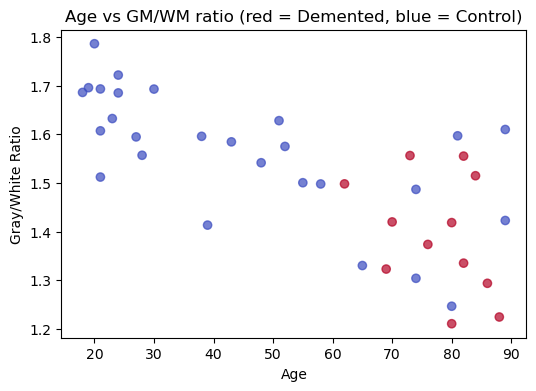

In [ ]:
if "Age" not in df.columns:
    print("Available columns:", df.columns.tolist())
    raise KeyError("Column 'age' not found. Check metadata; after standardization it should be 'age'.")

plt.figure(figsize=(6,4))
plt.scatter(df["Age"], df["gm_wm_ratio"], c=df["label"], cmap="coolwarm", alpha=0.7)
plt.xlabel("Age")
plt.ylabel("Gray/White Ratio")
plt.title("Age vs GM/WM ratio (red = Demented, blue = Control)")
plt.show()


In [ ]:
# 1) Normalize tissue volumes by intracranial size (brain_total)
for t in ["gm","wm","csf"]:
    df[f"{t}_norm"] = df[t] / df["brain_total"]

# 2) Define feature sets to try
feature_sets = {
    "norm_only":        ["gm_norm","wm_norm","csf_norm","gm_wm_ratio"],
    "norm_plus_age":    ["gm_norm","wm_norm","csf_norm","gm_wm_ratio","Age"],
    "age_only":         ["Age"],  # baseline check
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

def eval_model(name, estimator, X, y):
    auc = cross_val_score(estimator, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
    acc = cross_val_score(estimator, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
    return {"model": name, "AUC_mean": auc.mean(), "AUC_std": auc.std(), "ACC_mean": acc.mean(), "ACC_std": acc.std()}

y = df["label"].astype(int)

results = []

# 3) Class-balanced, tuned SVM (small grid)
for feat_name, feats in feature_sets.items():
    X = df[feats].values
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(probability=True, class_weight="balanced", random_state=42))
    ])
    grid = {
        "svc__C": [0.1, 1, 10],
        "svc__gamma": ["scale", 0.1, 0.01],
        "svc__kernel": ["rbf"]
    }
    gs = GridSearchCV(pipe, grid, cv=cv, scoring="roc_auc", n_jobs=-1)
    gs.fit(X, y)
    results.append(eval_model(f"SVM[{feat_name}] (best={gs.best_params_})", gs.best_estimator_, X, y))

# 4) Class-balanced Logistic Regression (L2)
for feat_name, feats in feature_sets.items():
    X = df[feats].values
    lr = LogisticRegression(max_iter=500, class_weight="balanced", solver="liblinear", random_state=42)
    pipe = Pipeline([("scaler", StandardScaler()), ("lr", lr)])
    results.append(eval_model(f"LR[{feat_name}]", pipe, X, y))

# 5) Random Forest with class weights
for feat_name, feats in feature_sets.items():
    X = df[feats].values
    rf = RandomForestClassifier(
        n_estimators=400, max_depth=None, min_samples_leaf=2,
        class_weight="balanced", random_state=42
    )
    results.append(eval_model(f"RF[{feat_name}]", rf, X, y))

import pandas as pd
df_cv = pd.DataFrame(results).sort_values("AUC_mean", ascending=False)
df_cv


,model,AUC_mean,AUC_std,ACC_mean,ACC_std
2,"SVM[age_only] (best={'svc__C': 0.1, 'svc__gamm...",0.881000,0.121964,0.765714,0.130180
5,LR[age_only],0.856333,0.143861,0.797857,0.108881
1,"SVM[norm_plus_age] (best={'svc__C': 1, 'svc__g...",0.834667,0.149883,0.812857,0.109861
0,"SVM[norm_only] (best={'svc__C': 10, 'svc__gamm...",0.827333,0.140940,0.812857,0.109861
4,LR[norm_plus_age],0.820667,0.147142,0.797857,0.108881
3,LR[norm_only],0.818000,0.156555,0.792857,0.108091
8,RF[age_only],0.799667,0.148071,0.696429,0.115507
6,RF[norm_only],0.797333,0.148824,0.772857,0.147472
7,RF[norm_plus_age],0.784000,0.131949,0.737857,0.137833


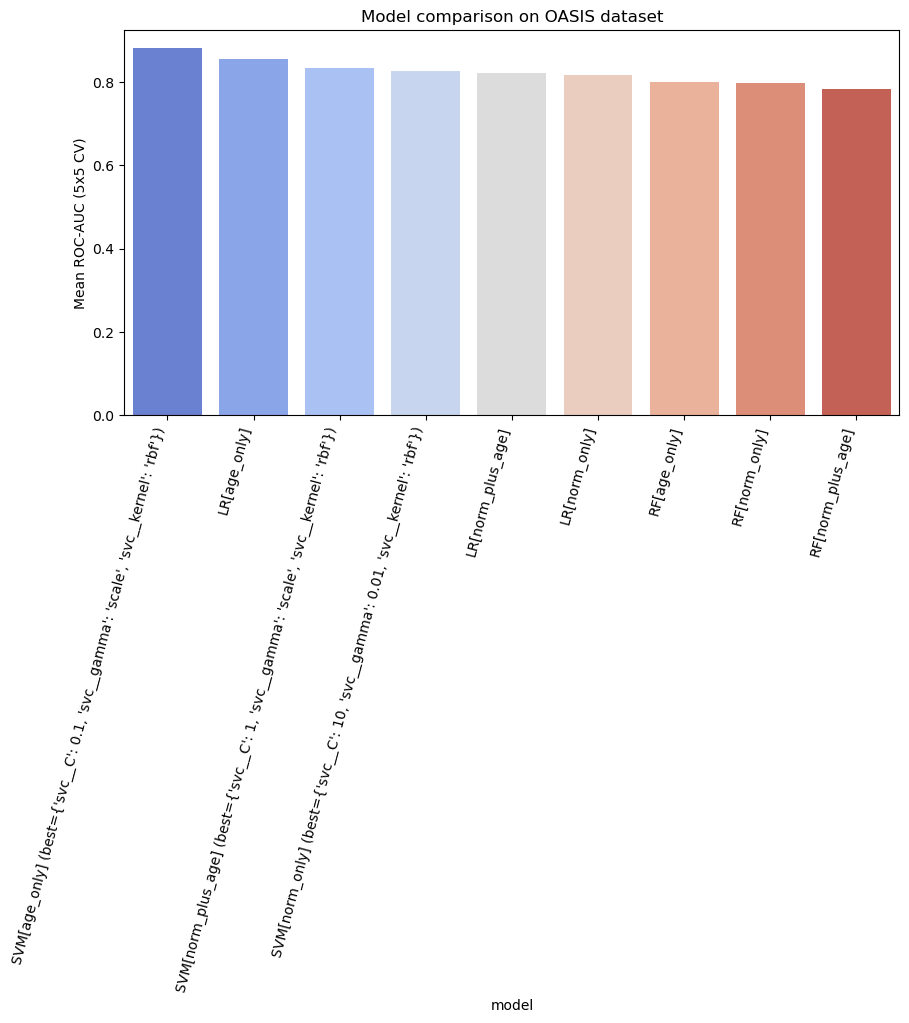

In [22]:
import seaborn as sns
plt.figure(figsize=(10,5))
sns.barplot(data=df_cv, x="model", y="AUC_mean", palette="coolwarm")
plt.xticks(rotation=75, ha='right')
plt.ylabel("Mean ROC-AUC (5x5 CV)")
plt.title("Model comparison on OASIS dataset")
plt.show()
